In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Reproducibility: fix random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 代码块 1: 导入库与环境设置

#### 总体解释
此单元格是项目的“启动台”。它不仅导入了所有必需的Python库，还通过设置固定的随机种子来确保实验的可复现性，并智能地配置计算设备（优先使用GPU）。

#### 逐行/逐段详解

-   **`import ...`**:
    -   `os`, `random`: Python标准库，分别用于处理文件路径和生成随机数。
    -   `numpy as np`: Python科学计算的基础库，用于高效处理多维数组（矩阵）。是数据预处理阶段的主力。
    -   `pandas as pd`: 强大的数据分析库，尤其擅长处理表格数据，如此处的CSV文件。
    -   `matplotlib.pyplot as plt`: 最常用的数据可视化库，用于绘制训练曲线、显示图像等。
    -   `torch`, `torch.nn as nn`, `torch.optim as optim`: PyTorch三巨头。`torch`是核心张量库；`nn`是构建神经网络所有组件（层、损失函数等）的模块；`optim`包含各种优化算法（如Adam）用于更新模型权重。
    -   `torch.utils.data.Dataset, DataLoader`: PyTorch数据加载的标准工具链。`Dataset`是对数据的抽象封装，`DataLoader`则负责高效地迭代、分批和打乱数据。
    -   `torchvision.transforms`: `torchvision`是PyTorch的官方计算机视觉库，`transforms`模块提供了丰富的即用型图像预处理和数据增强功能。
    -   `sklearn...`: Scikit-learn是经典的机器学习库。我们借用它的`train_test_split`来方便地划分数据集，并用`confusion_matrix`, `accuracy_score`来评估模型性能。

-   **`# Reproducibility: fix random seeds`**:
    -   **目的**: 保证代码每次运行时都能产生完全相同的结果。在深度学习中，权重的初始值、数据的打乱顺序、Dropout层的掩码等都依赖于随机数生成器。固定种子能消除这种随机性，这对于调试错误、验证改动效果和公平比较不同模型至关重要。
    -   **`seed = 42`**: 选定一个整数作为种子。42是《银河系漫游指南》中的梗，本身无特殊意义。
    -   **`random.seed(seed)`**, **`np.random.seed(seed)`**: 分别为Python内置的`random`库和`numpy`库设置随机种子。
    -   **`torch.manual_seed(seed)`**: 为所有CPU上的PyTorch操作设置种子。
    -   **`torch.cuda.manual_seed_all(seed)`**: 为所有GPU上的PyTorch操作设置种子（如果代码在多GPU上运行，这能确保所有GPU的随机性一致）。

-   **`# Device configuration: use GPU if available`**:
    -   **`device = torch.device(...)`**: 创建一个代表计算设备的对象。
    -   **`torch.cuda.is_available()`**: 这是PyTorch用来检测系统中是否存在可用NVIDIA GPU和正确安装的CUDA环境的函数。
    -   **`"cuda" if ... else "cpu"`**: 一个简洁的三元表达式。如果GPU可用，`device`对象将指向`"cuda"`；否则，它将指向`"cpu"`。
    -   **拓展**: 后续代码中，我们会频繁使用 `.to(device)` 方法，将模型参数和数据张量从内存（CPU）转移到显存（GPU）。在GPU上进行大规模并行计算是深度学习训练速度的关键。

In [4]:
DATA_PATH = "../../kaggle_data/digit-recognizer/"
train_data = pd.read_csv(DATA_PATH+"train.csv")
test_data = pd.read_csv(DATA_PATH+'test.csv')

In [17]:
train_labels = train_data['label'].values
train_images = train_data.drop('label', axis=1).values
test_images = test_data.values

### 代码块 2 & 3: 加载数据并分离标签

#### 总体解释
这两步负责数据的初始加载和整理。使用`pandas`从CSV文件读取数据后，将其拆分为包含图像像素的Numpy数组和包含对应数字标签的Numpy数组。

#### 逐行详解

-   **`DATA_PATH = ...`**: 定义数据文件所在目录的路径，便于管理。
-   **`train_data = pd.read_csv(...)`**: 使用`pandas`读取`train.csv`。它会将整个CSV文件加载成一个**DataFrame**对象。你可以把DataFrame想象成一个功能更强大的电子表格，有行索引和列标签。
-   **`test_data = pd.read_csv(...)`**: 同理，加载测试数据。
-   **`train_labels = train_data['label'].values`**:
    -   `train_data['label']`: 通过列名 `'label'` 从DataFrame中选取这一整列。这会得到一个Pandas Series对象。
    -   `.values`: 调用`.values`属性，将这个Series对象转换成一个一维的Numpy数组，其中只包含纯粹的标签数据。
-   **`train_images = train_data.drop('label', axis=1).values`**:
    -   `train_data.drop('label', axis=1)`: `drop`方法用于移除指定的行或列。`'label'`是要移除的列名，`axis=1`明确指示操作对象是**列**（`axis=0`则代表行）。此操作会返回一个新的、不包含`label`列的DataFrame。
    -   `.values`: 同样，将处理后的DataFrame转换为一个二维的Numpy数组。此时，每一行是一张展平的图像，每一列是一个像素点。
-   **`test_images = test_data.values`**: 测试数据中没有`label`列，所以直接将整个DataFrame转换为Numpy数组。

In [18]:
test_images.shape

(28000, 784)

In [19]:
# Normalize pixel values

train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)

print(f'Train images: {train_images.shape}, Train labels: {train_labels.shape}')
print(f'Test images: {test_images.shape}')

Train images: (42000, 28, 28), Train labels: (42000,)
Test images: (28000, 28, 28)


### 代码块 5: 数据预处理和重塑

#### 总体解释
这是至关重要的数据预处理步骤。它将原始的、一维的、整数像素值转换成适合输入卷积神经网络的、标准化的、二维的浮点数图像格式。

#### 逐行详解

-   **`train_images = train_images.astype(np.float32) / 255.0`**: 这一行做了两件事：
    1.  **`astype(np.float32)`**: **类型转换**。原始像素值是0-255的8位整数（`int8`）。神经网络中的计算通常使用32位浮点数（`float32`），这提供了更高的精度。
    2.  **`/ 255.0`**: **归一化 (Normalization)**。将每个像素值都除以255，把数据范围从 `[0, 255]` 缩放到 `[0.0, 1.0]`。
        -   **拓展与深化**: 为什么要归一化？
            -   **加速收敛**: 使得数据分布在一个较小的范围内，有助于优化算法（如梯度下降）更快地找到最优解。
            -   **提高稳定性**: 防止在深层网络中由于数值累乘导致的梯度爆炸或消失问题。
            -   **一视同仁**: 确保所有特征（此处是像素点）都在相似的尺度上，模型不会因为某些像素值范围更大而给予它们不应有的“关注”。

-   **`train_images = train_images.reshape(-1, 28, 28)`**:
    -   **重塑 (Reshape)**: 原始数据中每张图像是一个长度为784的一维向量。卷积神经网络(CNN)的设计初衷是为了处理具有空间结构的数据（如图像），它需要输入是二维或三维的。
    -   `reshape`函数将这个一维向量“折叠”回它本来的`28x28`像素的二维矩阵形式。
    -   `-1`: 这是`reshape`中的一个“魔法”参数。它告诉Numpy：“我不想自己计算这个维度的大小，请你根据数组的总元素数量和其它给定的维度（28, 28）自动推断出来”。在这里，它就代表了数据集中图像的总数。
    -   **维度变化追踪**: `(42000, 784)` -> `(42000, 28, 28)`。

-   **`print(...)`**: 打印出处理后数组的形状，这是一个好习惯，可以立即验证我们的操作是否符合预期。

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=seed,
)
print(f'Train split: {X_train.shape}, Validation split: {X_val.shape}')

Train split: (33600, 28, 28), Validation split: (8400, 28, 28)


### 代码块 6: 划分训练集和验证集

#### 总体解释
使用`scikit-learn`的工具函数，将训练数据分割成“训练集”和“验证集”。模型将在训练集上学习，而在验证集上评估其泛化能力，这是监控和防止**过拟合**的关键步骤。

#### 逐行/逐参数详解

-   **`X_train, X_val, y_train, y_val = train_test_split(...)`**: `train_test_split`函数会返回四个打乱顺序后的数据集：训练集特征(`X_train`)、验证集特征(`X_val`)、训练集标签(`y_train`)、验证集标签(`y_val`)。
-   **`train_images, train_labels`**: 需要被划分的原始数据和标签。
-   **`test_size=0.2`**: 指定验证集的大小。`0.2`意味着将原始数据的20%划为验证集，剩下的80%作为训练集。
-   **`stratify=train_labels`**: **分层抽样**。这是一个非常重要的参数，尤其是在分类任务中。
    -   **拓展与深化**: 它的作用是确保在划分数据时，训练集和验证集中的每个类别（即数字0-9）的样本比例与原始数据集中完全一致。例如，如果原始数据中数字"7"占10%，那么划分后，训练集中的"7"和验证集中的"7"也都将约占10%。这可以防止因随机划分不均，导致验证集缺少某些类别的样本，从而使评估指标（如准确率）变得不可靠。
-   **`random_state=seed`**: 使用我们之前定义的`seed`来控制划分过程中的随机性，确保每次运行代码时，划分的结果都是一模一样的。

In [30]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, int(self.labels[idx])
        else:
            return img
        
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNISTDataset(X_train, y_train, transform=train_transform)
val_dataset = MNISTDataset(X_val, y_val, transform=test_transform)
test_dataset = MNISTDataset(test_images, labels=None, transform=test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 代码块 7: 创建PyTorch的Dataset和DataLoader

#### 总体解释
这是将我们的Numpy数据接入PyTorch训练框架的标准流程。`Dataset`定义了“有什么数据”以及“如何获取单个数据”，而`DataLoader`则定义了“如何批量、高效地提供数据给模型”。

#### 逐段详解

1.  **`class MNISTDataset(Dataset)`**:
    -   继承自`torch.utils.data.Dataset`，这是所有PyTorch自定义数据集的基类。我们必须实现两个核心方法：`__len__`和`__getitem__`。
    -   **`__init__(self, images, labels=None, transform=None)`**: 构造函数。当创建`MNISTDataset`实例时，它会接收图像数据、标签数据（可选，因为测试集没有标签）和图像变换，并将它们存储为类的属性。
    -   **`__len__(self)`**: 这个方法必须返回数据集中样本的总数。`DataLoader`会调用它来确定迭代的次数。
    -   **`__getitem__(self, idx)`**: 这是`Dataset`的核心。它定义了如何根据给定的索引`idx`来获取和处理**一个**数据样本。
        -   `img = self.images[idx]`: 从Numpy数组中取出第`idx`张图像。
        -   `img = transforms.ToPILImage()(img)`: `torchvision`中的许多变换操作是为PIL（Python Imaging Library）图像对象设计的。这一行将Numpy数组格式的`28x28`图像转换为PIL图像对象。
        -   `if self.transform: img = self.transform(img)`: 如果在创建`Dataset`时传入了`transform`，就在这里将这些变换应用到PIL图像上。
        -   `if self.labels is not None: return img, int(self.labels[idx])`: 如果有标签，就返回一个元组，包含处理后的图像张量和对应的整数标签。
        -   `else: return img`: 如果没有标签（测试集），就只返回处理后的图像张量。

2.  **`train_transform` 和 `test_transform`**:
    -   `transforms.Compose([...])`: 这是一个容器，可以将多个变换操作按顺序串联起来。
    -   **`train_transform`**: 应用于训练数据的变换。
        -   `transforms.RandomRotation(15)`: **数据增强(Data Augmentation)**。在每次从数据集中取出一张训练图片时，都会以-15到+15度之间的随机角度对其进行旋转。
            -   **拓展与深化**: 数据增强的目的是在不改变标签的情况下，人工创造出更多样化的训练数据。这能迫使模型学习到更本质、更具鲁棒性的特征（比如一个稍微倾斜的"5"仍然是"5"），从而有效减轻**过拟合**，提高模型在未见过数据上的表现。
        -   `transforms.ToTensor()`: 这是一个关键的变换。它会将PIL图像或Numpy数组转换成PyTorch的张量，同时做两件事：1) 将像素值从`[0, 255]`范围缩放到`[0.0, 1.0]`范围；2) 将图像的维度顺序从`(H, W, C)`（高, 宽, 通道）调整为PyTorch期望的`(C, H, W)`。对于我们的灰度图，维度从`(28, 28)`变为`(1, 28, 28)`。
        -   `transforms.Normalize((0.1307,), (0.3081,))`: 进一步的标准化。它使用公式 `output = (input - mean) / std` 对张量进行处理。`(0.1307,)`和`(0.3081,)`分别是MNIST数据集所有像素的全局平均值和标准差（这是公开的、预计算好的值）。这使得数据分布近似于标准正态分布（均值为0，标准差为1），更有利于模型训练。
    -   **`test_transform`**: 应用于验证集和测试集。**注意**，这里**没有**数据增强步骤（如`RandomRotation`）。因为在评估模型时，我们希望在原始、一致的数据上进行，以获得稳定、可复现的性能分数。

3.  **`DataLoader`**:
    -   `train_loader = DataLoader(..., shuffle=True)`: 创建训练数据加载器。
        -   `batch_size=128`: 设定批大小。模型每次“看”128张图片，计算这128张图片的平均梯度来更新权重，而不是一张一张地更新。这既利用了硬件的并行计算能力，也使得梯度下降的方向更稳定。
        -   `shuffle=True`: **极其重要**。在每个epoch开始前，`DataLoader`会彻底打乱训练数据的顺序。这可以防止模型学习到数据本身的排列顺序，破坏批次间的相关性，从而增强模型的泛化能力。
    -   `val_loader`, `test_loader`: 为验证集和测试集创建加载器。`shuffle=False`因为在评估时顺序无关紧要，不打乱可以稍微提高速度，并保证每次评估的顺序一致。

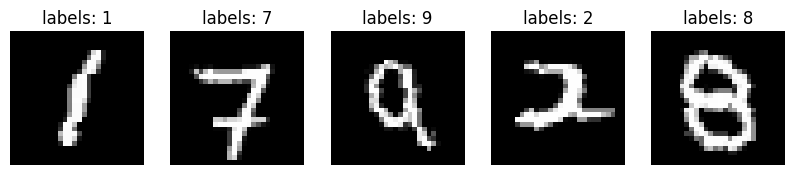

In [39]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1,5, figsize=(10,2))
for i in range(5):
    ax = axes[i]
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'labels: {labels[i].item()}')
    ax.axis('off')

plt.show()

In [45]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        
model = MNIST_CNN().to(device)
print(model)

MNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(

### 代码块 9: 定义CNN模型

#### 总体解释
这里我们用PyTorch的`nn.Module`来构建一个经典的卷积神经网络（CNN）。模型被清晰地划分为`features`（用于从图像中提取层次化特征的卷积部分）和`classifier`（用于根据提取的特征进行分类的全连接部分）。

#### 逐行/逐段详解

-   **`class MNIST_CNN(nn.Module)`**: 定义一个名为`MNIST_CNN`的类，它必须继承自`nn.Module`。这是所有PyTorch模型的基类，它提供了参数追踪、子模块管理等核心功能。

-   **`__init__(self)`**: 构造函数。在这里，我们“声明”模型需要用到的所有层，并将它们作为类的属性。
    -   **`self.features = nn.Sequential(...)`**: `nn.Sequential`是一个有序的容器。数据会按照定义的顺序依次通过其中的每一层。
        -   **卷积块1**:
            -   `nn.Conv2d(1, 32, kernel_size=3, padding=1)`: 2D卷积层。`in_channels=1` (输入是单通道灰度图), `out_channels=32` (希望学习32种不同的特征), `kernel_size=3` (使用3x3的卷积核), `padding=1` (在图像周围补一圈0，使得经过3x3卷积后，图像尺寸保持不变：28x28 -> 28x28)。
            -   `nn.BatchNorm2d(32)`: 批标准化层。对32个输出通道进行标准化。**拓展**: 它能有效解决“内部协变量偏移”问题，使每一层的输入分布相对稳定，从而可以设置更高的学习率，加速训练，并自带一定的正则化效果。
            -   `nn.ReLU(inplace=True)`: ReLU激活函数，引入非线性，使模型能学习更复杂的关系。`inplace=True`是一个内存优化，它会直接在原地修改输入数据，而不是创建新的输出，可以节省少量内存。
            -   `nn.MaxPool2d(2)`: 2x2的最大池化层。它将特征图尺寸减半（28x28 -> 14x14），通过只保留每个2x2区域中的最大值来减少计算量、降低过拟合风险，并使模型对特征的微小位移不敏感。
        -   **卷积块2 & 3**: 结构类似，但通道数不断增加（32 -> 64 -> 128），提取的特征也从简单的边缘、角点等向更复杂的纹理、部件等演变。图像尺寸则继续减小（14x14 -> 7x7）。

    -   **`self.classifier = nn.Sequential(...)`**: 分类器部分。
        -   `nn.Dropout(p=0.5)`: Dropout层，在训练时会以50%的概率随机将上一层的输出神经元置为0。**拓展**: 这是一种强大的正则化技术，它强迫网络不能过度依赖任何一个神经元，而是要学习到更具鲁棒性的分布式特征表示，能有效防止过拟合。
        -   `nn.Linear(128 * 7 * 7, 128)`: 全连接层（或线性层）。
            -   `in_features=128 * 7 * 7`: 输入特征数。这个数字是这样计算的：`features`部分的最终输出是一个`128`通道的`7x7`特征图，展平后就是一个长度为 `128 * 7 * 7 = 6272` 的向量。
            -   `out_features=128`: 该层输出128个特征。
        -   **`nn.Linear(64, 10)`**: 最后一层。输出特征数为10，因为我们有10个类别（数字0-9）。这一层的输出被称为**logits**，即未经Softmax激活的原始预测分数。

-   **`forward(self, x)`**: 定义了**前向传播**的逻辑，即数据`x`如何一步步流经我们定义的各个层。
    -   `x = self.features(x)`: 输入`x`首先通过整个`features`模块。
    -   `x = x.view(x.size(0), -1)`: **展平(Flatten)** 操作。这是连接卷积层和全连接层的桥梁。
        -   `x.size(0)`是批大小（batch size）。
        -   `.view(x.size(0), -1)` 的意思是“保持第一个维度（批大小）不变，将后面所有维度（通道、高、宽）合并成一个单一的维度”。
        -   **维度变化追踪**: `(batch_size, 128, 7, 7)` -> `(batch_size, 6272)`。
    -   `x = self.classifier(x)`: 展平后的向量通过分类器，得到最终的`logits`。

-   **`model = MNIST_CNN().to(device)`**: 创建模型的一个实例，并调用`.to(device)`将其所有参数（权重和偏置）和缓冲区（如BatchNorm的均值和方差）移动到我们之前配置好的GPU或CPU上。

In [46]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}/{num_epochs}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}')



Epoch 1/50: Train Loss = 0.6440, Val Loss = 0.5498, Val Acc = 0.9868
Epoch 2/50: Train Loss = 0.6148, Val Loss = 0.5484, Val Acc = 0.9868
Epoch 3/50: Train Loss = 0.6014, Val Loss = 0.5448, Val Acc = 0.9901
Epoch 4/50: Train Loss = 0.5884, Val Loss = 0.5351, Val Acc = 0.9905
Epoch 5/50: Train Loss = 0.5810, Val Loss = 0.5388, Val Acc = 0.9902
Epoch 6/50: Train Loss = 0.5775, Val Loss = 0.5408, Val Acc = 0.9904
Epoch 7/50: Train Loss = 0.5707, Val Loss = 0.5470, Val Acc = 0.9898
Epoch 8/50: Train Loss = 0.5691, Val Loss = 0.5452, Val Acc = 0.9918
Epoch 9/50: Train Loss = 0.5626, Val Loss = 0.5386, Val Acc = 0.9914
Epoch 10/50: Train Loss = 0.5603, Val Loss = 0.5463, Val Acc = 0.9936
Epoch 11/50: Train Loss = 0.5595, Val Loss = 0.5503, Val Acc = 0.9924
Epoch 12/50: Train Loss = 0.5561, Val Loss = 0.5475, Val Acc = 0.9933
Epoch 13/50: Train Loss = 0.5514, Val Loss = 0.5596, Val Acc = 0.9938
Epoch 14/50: Train Loss = 0.5478, Val Loss = 0.5617, Val Acc = 0.9923
Epoch 15/50: Train Loss = 0.5

### 代码块 11: 训练循环

#### 总体解释
这是模型学习过程的核心。它通过`num_epochs`个周期的迭代，让模型反复“看”训练数据并调整自身参数以减小损失，同时在每个周期结束时用验证集来评估模型的泛化性能。

#### 训练阶段 (`for epoch in ...`)
-   **`model.train()`**: **切换到训练模式**。这是一个必须的步骤！它会告诉模型中的特定层（如`Dropout`和`BatchNorm`）要进入训练状态。`Dropout`会开始随机丢弃神经元，`BatchNorm`会使用当前批次的均值和方差进行归一化。

-   **`for images, labels in train_loader:`**: 从`DataLoader`中循环取出每一批次的数据。

-   **`images, labels = images.to(device), labels.to(device)`**: 将当前批次的图像和标签数据从CPU内存转移到GPU显存（如果`device`是`"cuda"`）。模型和数据必须在同一个设备上才能进行计算。

-   **`optimizer.zero_grad()`**: **梯度清零**。PyTorch的梯度是累加的。因此，在计算新一轮的梯度之前，必须手动将上一轮的梯度清零。否则，梯度会一直累积，导致错误的参数更新。

-   **`outputs = model(images)`**: **前向传播**。将图像数据输入模型，执行`forward`方法中定义的计算流程，得到模型的原始输出（logits）。

-   **`loss = criterion(outputs, labels)`**: **计算损失**。将模型的输出和真实的标签传入损失函数（`CrossEntropyLoss`），计算出两者之间的差距。损失值越小，代表模型预测得越准。

-   **`loss.backward()`**: **反向传播**。这是PyTorch自动求导引擎的魔力所在。调用`.backward()`后，PyTorch会自动计算出损失`loss`相对于模型中**每一个可训练参数**的梯度（偏导数）。

-   **`torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)`**: **梯度裁剪**。这是一个正则化技巧，用于防止**梯度爆炸**。如果梯度的L2范数超过了`max_norm`（这里是1.0），就会按比例缩放梯度，使其范数恰好等于`max_norm`。这在训练RNN或非常深的网络时尤其有用，能提高训练的稳定性。

-   **`optimizer.step()`**: **参数更新**。优化器（Adam）会根据`.backward()`计算出的梯度，以及自身的学习率等设置，来更新模型的所有参数（`model.parameters()`），使损失向减小的方向移动。

-   **`running_loss += loss.item() * images.size(0)`**: 累加损失。
    -   `loss.item()`: `loss`是一个包含单个值的张量，`.item()`可以将其中的Python数值提取出来。这很重要，因为它能将数值与计算图分离，防止内存占用不断增长。
    -   `* images.size(0)`: `loss`是当前批次的平均损失，乘以批大小（`images.size(0)`）得到当前批次的总损失。这样累加，最后除以数据集总数，可以得到精确的平均损失，即使最后一个批次的大小可能不完整。

#### 验证阶段 (`model.eval()`)
-   **`model.eval()`**: **切换到评估模式**。这也是一个必须的步骤！它会告诉`Dropout`和`BatchNorm`等层进入评估状态。`Dropout`层会停止工作（即通过所有神经元），`BatchNorm`会使用在整个训练过程中学习到的全局均值和方差来进行归一化，而不是当前批次的统计量。这保证了在评估时，对于同一个输入，模型的输出是确定性的。

-   **`with torch.no_grad():`**: 这是一个上下文管理器，它会临时禁用所有梯度计算。
    -   **拓展与深化**: 在这个代码块内部，所有PyTorch操作都不会被追踪，不会构建计算图。这样做有两大好处：1) **速度更快**，因为省去了梯度计算的开销；2) **内存更省**，因为不需要存储中间激活值用于反向传播。这在评估和推理时是最佳实践。

-   **`preds = outputs.argmax(dim=1)`**: 找到预测结果。`outputs`的形状是`(batch_size, 10)`，每一行是对应一张图片的10个类别的logits。`argmax(dim=1)`会沿着第二个维度（类别维度）找到值最大的那个元素的索引。这个索引就是模型预测的数字。

-   **`correct += (preds == labels).sum().item()`**: 计算正确预测的数量。
    -   `preds == labels`: 逐元素比较预测和真实标签，得到一个布尔张量（`True`或`False`）。
    -   `.sum()`: 对布尔张量求和，`True`被当作1，`False`被当作0。结果是当前批次预测正确的样本数。
    -   `.item()`: 将这个单元素张量转换为Python数字。

-   **`print(...)`**: 在每个epoch结束后，打印出训练损失、验证损失和验证准确率，让我们能实时监控模型的学习进展。

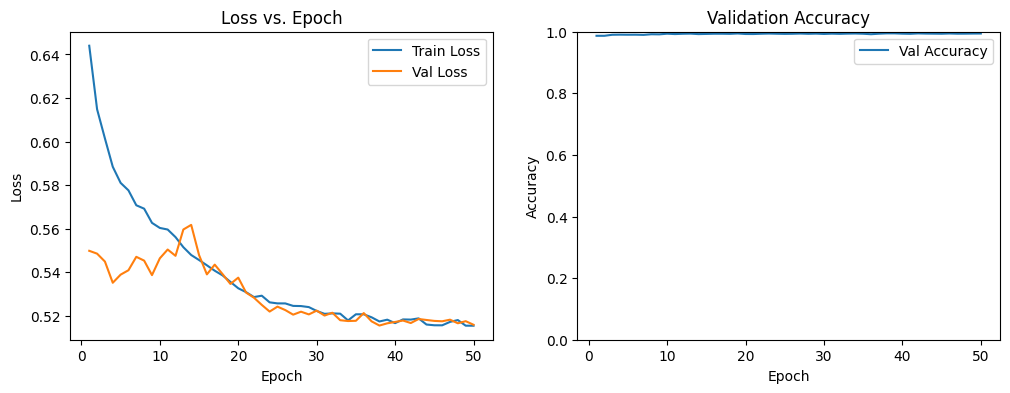

In [49]:
# Plot training and validation curves
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0); plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [50]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[824   0   0   0   0   0   2   0   0   1]
 [  0 935   1   0   0   0   0   1   0   0]
 [  0   0 832   0   1   0   0   2   0   0]
 [  1   0   1 864   0   2   0   1   1   0]
 [  0   2   0   0 809   0   1   0   0   2]
 [  0   0   0   1   0 753   2   0   2   1]
 [  1   0   0   0   1   0 825   0   0   0]
 [  0   2   0   1   2   0   0 873   0   2]
 [  1   0   2   0   0   0   2   0 804   4]
 [  2   0   0   0   1   1   0   1   1 832]]


In [51]:
# Normalize confusion matrix for visualization (optional)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
print("Per-class accuracy:", np.diag(cm_norm))

Per-class accuracy: [0.99637243 0.99786553 0.99640719 0.99310345 0.99385749 0.99209486
 0.99758162 0.99204545 0.98892989 0.9928401 ]


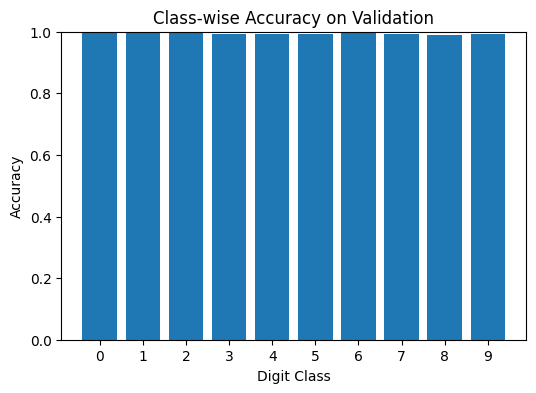

In [52]:
classes = [str(i) for i in range(10)]
acc_per_class = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(classes, acc_per_class)
plt.ylim(0,1.0)
plt.xlabel('Digit Class'); plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy on Validation')
plt.show()

### 代码块 13-15: 混淆矩阵和分类准确率分析

#### 总体解释
在模型训练结束后，我们不再只满足于一个总的准确率，而是要深入分析模型在验证集上的具体表现。混淆矩阵是进行这种精细化错误分析的绝佳工具。

#### 逐段详解

1.  **收集所有预测和标签**:
    -   代码首先将模型切换到`model.eval()`模式，并使用`with torch.no_grad()`来高效地遍历整个`val_loader`。
    -   它将每一批次的预测结果`preds`和真实标签`labels`收集起来，并从GPU移回CPU（`.cpu()`），再转换为Numpy数组（`.numpy()`）。
    -   `np.concatenate(...)`: 最后，将所有批次的Numpy数组拼接成一个大的数组，`all_preds`和`all_labels`，分别包含了对整个验证集的所有预测和真实标签。

2.  **计算并打印混淆矩阵**:
    -   `cm = confusion_matrix(all_labels, all_preds)`: `sklearn`的`confusion_matrix`函数接收真实标签和预测标签，生成一个混淆矩阵`cm`。
    -   **拓展与深化**: 如何解读混淆矩阵？
        -   它是一个N x N的方阵（此处是10x10）。
        -   矩阵的**行**代表**真实类别**，**列**代表**预测类别**。
        -   `cm[i, j]`的值表示真实为`i`类的样本被模型预测为`j`类的数量。
        -   **对角线元素 `cm[i, i]`** 是被正确分类的样本数（真实为`i`，预测也为`i`）。
        -   **非对角线元素 `cm[i, j]` (i != j)** 是被错误分类的样本数。这些值越大，说明模型越容易把`i`和`j`搞混。例如，如果`cm[4, 9]`很大，说明模型经常把"4"错认成"9"。

3.  **计算并打印各类别准确率**:
    -   `cm.diagonal()`: 获取混淆矩阵的对角线元素，即每个类别被正确预测的数量。
    -   `cm.sum(axis=1)`: 沿着行（`axis=1`）求和，得到每个类别的总样本数。
    -   `cm.diagonal() / cm.sum(axis=1)`: 两者相除，就得到了每个类别的**召回率（Recall）**，也常被称为该类别的准确率。它衡量了对于某个特定类别，模型能把它正确认出来的能力。

4.  **可视化**:
    -   使用`matplotlib`的条形图(`plt.bar`)将每个类别的准确率直观地展示出来。这能让我们一目了然地看到模型的“强项”和“弱项”。

In [53]:
model.eval()
image_ids = []
predictions = []

with torch.no_grad():
    for i, images in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        # Compute the corresponding ImageIds for this batch
        start_id = i * batch_size + 1
        for offset, pred in enumerate(preds):
            image_ids.append(start_id + offset)
            predictions.append(pred)

submission_df = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
submission_df.to_csv("submission.csv", index=False)
print(submission_df.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


### 代码块 16: 生成提交文件

#### 总体解释
这是项目的最后一步：应用我们训练好的模型到Kaggle提供的、没有标签的测试集上，生成预测结果，并将其保存为符合比赛提交要求的CSV文件。

#### 逐行详解
-   **`model.eval()`** 和 **`with torch.no_grad():`**: 同样，在进行最终预测（推理）时，必须将模型设置为评估模式并关闭梯度计算，以保证结果的确定性和高效性。

-   **`for i, images in enumerate(test_loader):`**:
    -   遍历测试数据加载器。
    -   `enumerate`是一个非常有用的Python函数，它在迭代的同时返回每个元素的索引`i`（从0开始）和元素本身`images`。我们需要这个索引`i`来计算`ImageId`。

-   **`preds = outputs.argmax(dim=1).cpu().numpy()`**: 获取预测结果，并将其转换为CPU上的Numpy数组，以便后续处理。

-   **`start_id = i * batch_size + 1`**: **计算ImageId**。Kaggle的`ImageId`通常是从1开始的。
    -   `i`是当前批次的索引（0, 1, 2, ...）。
    -   `i * batch_size`计算出之前所有批次已经处理过的图像总数。
    -   `+ 1`是因为ID从1开始，而不是0。
    -   例如，当`batch_size=128`：
        -   第0批 (`i=0`): `start_id = 0 * 128 + 1 = 1`
        -   第1批 (`i=1`): `start_id = 1 * 128 + 1 = 129`

-   **`for offset, pred in enumerate(preds):`**: 遍历当前批次中的每一个预测结果。
    -   `offset`是当前预测结果在批次内的索引（0, 1, 2, ..., 127）。
    -   `image_ids.append(start_id + offset)`: 计算出当前图像的全局唯一`ImageId`并存入列表。
    -   `predictions.append(pred)`: 存入对应的预测标签。

-   **`submission_df = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})`**: 使用`pandas`，将收集到的两个列表（`image_ids`和`predictions`）转换成一个DataFrame，并指定列名。

-   **`submission_df.to_csv("submission.csv", index=False)`**:
    -   `to_csv("submission.csv")`: 将DataFrame保存为名为`submission.csv`的文件。
    -   `index=False`: **至关重要**。默认情况下，`pandas`在保存CSV时会把自己的行索引（0, 1, 2, ...）也作为一列写入文件。Kaggle的评分系统不认识这一列，会导致提交失败。`index=False`可以阻止写入这个多余的索引列。